Changelog:  (Last Updated 2025-02-26)

# Probabilistic ML: Assignment 3
- **Deadline**: 2025-03-16 (March 16th 2025, 23:59)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.

- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [3]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b2e14e852cf9a6a094da0774edcdfe8b59e7982645d83eadac6b65335d4ae782
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [15]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [16]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 20.* logp_a_beats_b(z1, z2) \
        + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [17]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [19]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    D = len(mean)
    N = num_samples

    return torch.randn(N, D) * torch.exp(log_std) + mean # N,D


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    m = Normal(mean, torch.exp(log_std))

    return torch.sum(m.log_prob(x), axis=-1) # N,1


def batch_elbo(logprob, mean, log_std, num_samples):

    z_samples = diag_gaussian_samples(mean, log_std, num_samples) # N,D
    log_pz = logprob(z_samples) # N,1
    log_qz = diag_gaussian_logpdf(z_samples, mean, log_std) # N,1

    return (log_pz - log_qz).mean()



**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 20 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [20]:
# Hyperparameters
num_players = 2
n_iters = 1200
stepsize = 0.0001
num_samples_per_iter = 80

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
  return log_posterior_A_beat_B_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  return -batch_elbo(log_posterior_A_beat_B_20_times_1_arg,
                     params[0], params[1],
                     num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 20 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  4%|▍         | 54/1200 [00:00<00:02, 529.59it/s]

Iteration 0 lower bound 113.0113296508789
Iteration 25 lower bound 33.80327606201172
Iteration 50 lower bound 17.961841583251953
Iteration 75 lower bound 12.630179405212402
Iteration 100 lower bound 8.003499984741211


 18%|█▊        | 220/1200 [00:00<00:01, 548.86it/s]

Iteration 125 lower bound 7.321084499359131
Iteration 150 lower bound 5.417288780212402
Iteration 175 lower bound 5.2092204093933105
Iteration 200 lower bound 5.413758277893066
Iteration 225 lower bound 4.642623424530029


 27%|██▋       | 328/1200 [00:00<00:01, 525.28it/s]

Iteration 250 lower bound 4.582884788513184
Iteration 275 lower bound 4.173436641693115
Iteration 300 lower bound 4.287280082702637
Iteration 325 lower bound 4.005316734313965
Iteration 350 lower bound 3.966809034347534


 36%|███▋      | 438/1200 [00:00<00:01, 513.97it/s]

Iteration 375 lower bound 4.107111930847168
Iteration 400 lower bound 4.1917243003845215
Iteration 425 lower bound 3.9396567344665527
Iteration 450 lower bound 3.9867653846740723
Iteration 475 lower bound 4.09341287612915


 50%|█████     | 603/1200 [00:01<00:01, 529.99it/s]

Iteration 500 lower bound 3.9270598888397217
Iteration 525 lower bound 3.942662477493286
Iteration 550 lower bound 3.8693439960479736
Iteration 575 lower bound 3.9746317863464355
Iteration 600 lower bound 3.867778778076172


 60%|██████    | 723/1200 [00:01<00:00, 563.88it/s]

Iteration 625 lower bound 4.098381996154785
Iteration 650 lower bound 3.9894917011260986
Iteration 675 lower bound 3.9917209148406982
Iteration 700 lower bound 3.901383638381958
Iteration 725 lower bound 4.008879661560059


 70%|██████▉   | 839/1200 [00:01<00:00, 569.47it/s]

Iteration 750 lower bound 3.972303867340088
Iteration 775 lower bound 3.863671064376831
Iteration 800 lower bound 3.882340908050537
Iteration 825 lower bound 3.9790396690368652
Iteration 850 lower bound 3.907759189605713


 80%|███████▉  | 954/1200 [00:01<00:00, 540.84it/s]

Iteration 875 lower bound 3.9431254863739014
Iteration 900 lower bound 3.9236254692077637
Iteration 925 lower bound 3.867497682571411
Iteration 950 lower bound 3.948704481124878


 88%|████████▊ | 1062/1200 [00:01<00:00, 523.11it/s]

Iteration 975 lower bound 3.9782662391662598
Iteration 1000 lower bound 3.9066271781921387
Iteration 1025 lower bound 3.8822014331817627
Iteration 1050 lower bound 3.9593520164489746
Iteration 1075 lower bound 3.9612984657287598


100%|██████████| 1200/1200 [00:02<00:00, 537.72it/s]

Iteration 1100 lower bound 3.9908039569854736
Iteration 1125 lower bound 3.9235968589782715
Iteration 1150 lower bound 3.9889769554138184
Iteration 1175 lower bound 4.044143199920654
Final loss: 4.079136848449707


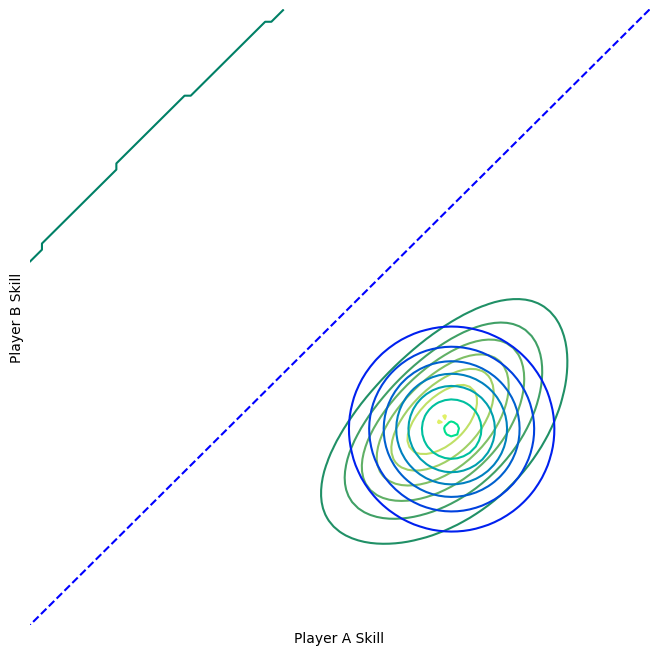

<Figure size 640x480 with 0 Axes>

In [25]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std  = torch.tensor([2.0] * D, requires_grad=True)
init_mean = torch.tensor([0.0] * D, requires_grad=True)


params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

final_loss = objective(params).item()
print(f"Final loss: {final_loss}")

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)


**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 20 games and player B winning 20 games.

Hint:  You can find analogous functions in the code above.


In [26]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    return log_posterior_beat_each_other_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_20_times_1_arg,
                      params[0], params[1],
                      num_samples_per_iter)

**e) [3pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

1. Any case where player A and B skills are approximately equal but both higher or lower than average are plausible in the true posterior but not in the approximate posterior
2. Using a fully parameterized covariance matrix and removing the independence assumption would make a better approximation because their skills are clearly correlated as indicated by the true posterior being stretched

Optimizing variational parameters...


100%|██████████| 100/100 [00:00<00:00, 537.06it/s]

Iteration 0 lower bound 32.77339172363281
Iteration 25 lower bound 31.649763107299805
Iteration 50 lower bound 30.551525115966797
Iteration 75 lower bound 30.276948928833008
Final loss: 30.633455276489258


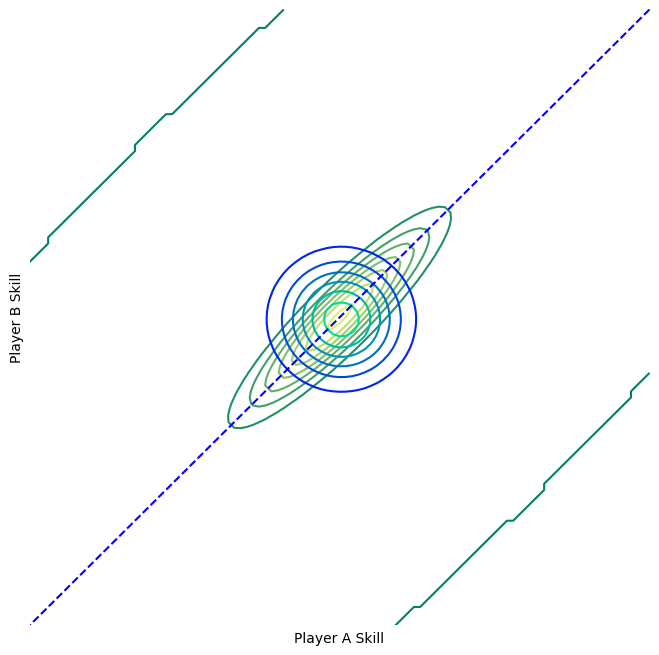

<Figure size 640x480 with 0 Axes>

In [28]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

final_loss = objective(params).item()
print(f"Final loss: {final_loss}")

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## 1.2 [34 pts] Approximate inference conditioned on real data

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022

<!-- The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess -->




In [29]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   250k      0 --:--:-- --:--:-- --:--:--  250k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [30]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()
games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [31]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [32]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [33]:
# Hyperparameters
num_players = 33
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def objective(params):
    return -batch_elbo(log_joint_probability,
                      params[0], params[1],
                      num_samples_per_iter)

**c) [3pts]** Optimize, and report the final loss.

In [34]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

final_loss = objective(params).item()
print(f"Final loss: {final_loss}")

Optimizing variational parameters...


  8%|▊         | 16/200 [00:00<00:01, 158.00it/s]

Iteration 0 lower bound 2254.04052734375
Iteration 25 lower bound 1700.213134765625


 34%|███▎      | 67/200 [00:00<00:00, 162.19it/s]

Iteration 50 lower bound 1582.807861328125
Iteration 75 lower bound 1550.82275390625


 59%|█████▉    | 118/200 [00:00<00:00, 161.44it/s]

Iteration 100 lower bound 1540.453125
Iteration 125 lower bound 1532.956298828125


 84%|████████▍ | 169/200 [00:01<00:00, 158.76it/s]

Iteration 150 lower bound 1525.82470703125
Iteration 175 lower bound 1522.286865234375


100%|██████████| 200/200 [00:01<00:00, 158.15it/s]

Final loss: 1519.36669921875


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

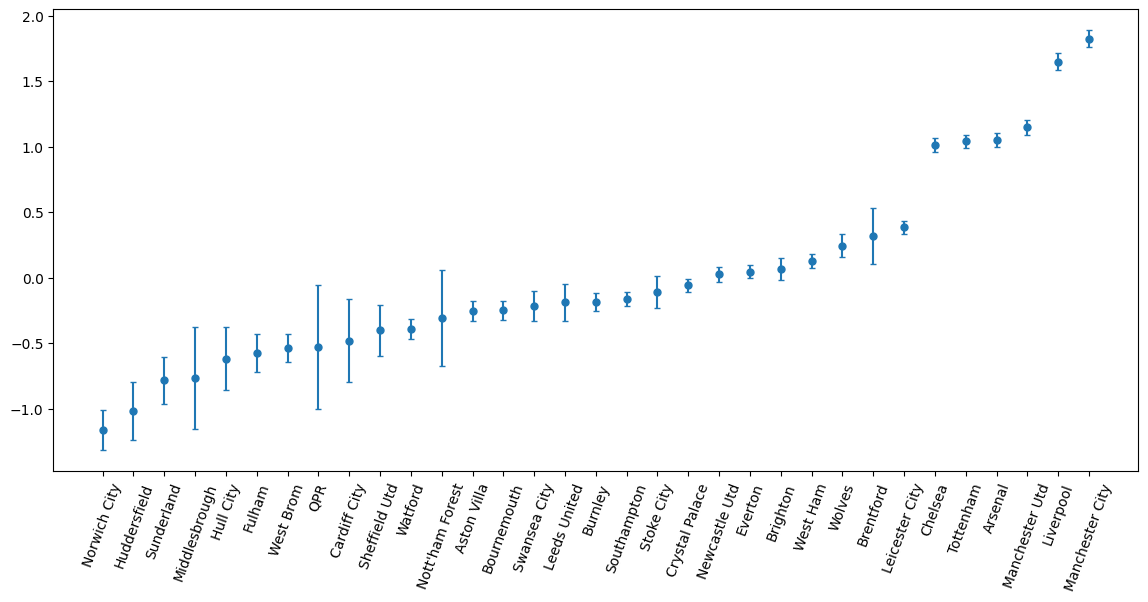

In [35]:
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
var_skills = torch.square(torch.exp(logstd_skills))

idx = np.argsort(mean_skills)

plt.figure(figsize=(14,6))
plt.errorbar(names[idx],mean_skills[idx],var_skills[idx],fmt='o', markersize=5,
             capsize=2)
plt.tick_params(axis='x', labelrotation=70)
plt.show()

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [36]:
names[idx[-10:]]

array(['West Ham', 'Wolves', 'Brentford', 'Leicester City', 'Chelsea',
       'Tottenham', 'Arsenal', 'Manchester Utd', 'Liverpool',
       'Manchester City'], dtype=object)

**f) [3pt]** Plot samples from the joint posterior over the skills of Arsenal and Liverpool. Based on your samples, describe in a sentence the relationship between the skills of the teams. (Is one better than the other? Are they approximately even?)

- Based on the samples, Liverpool is expected to be better than Arsenal

Arsenal
Liverpool


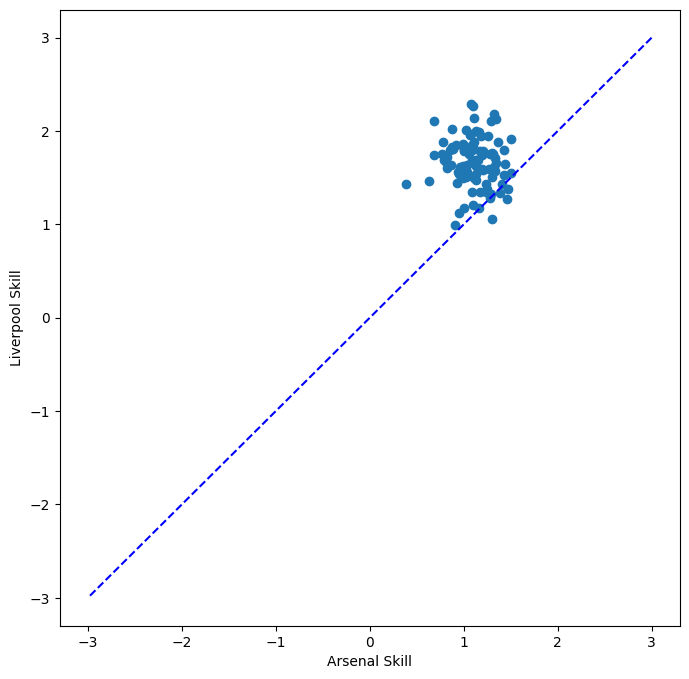

In [37]:
arsenal_ix = 0
liverpool_ix = 15
print(names[arsenal_ix])
print(names[liverpool_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Arsenal Skill")
plt.ylabel("Liverpool Skill")

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

plt.scatter(samples[:,0],samples[:,15])
plt.show()

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

\begin{split}
P(z_A > z_B) &= P(y_A + y_B > y_B) \\
&= P(y_A > 0) \\
&= 1-P(y_A \leq 0), \quad y_A \sim N(\mu_A - \mu_B, \sigma^2_A + \sigma^2_B) \\
&= 1- \int_{-\infty}^0 \frac{1}{\sqrt{2\pi(\sigma^2_A + \sigma^2_B)}}\cdot Exp \{-\frac{[y_A - (\mu_A - \mu_B)]^2}{2(\sigma^2_A + \sigma^2_B)} \}
\end{split}

**h) [4pts]** Compute the probability under your approximate posterior that Arsenal has higher skill than Liverpool. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [38]:
samples = diag_gaussian_samples(mean_skills, logstd_skills, 10000)

y_mean = torch.tensor([mean_skills[0] - mean_skills[15]])
y_std = torch.sqrt(var_skills[0] + var_skills[15])

exact = 1 - Normal(y_mean, y_std).cdf(torch.tensor([0]))
approx = (samples[:,0] > samples[:,15]).sum() / 10000

print("Monte Carlo Estimate: ", approx)
print("Exact: ", exact)


Monte Carlo Estimate:  tensor(0.0425)
Exact:  tensor([0.0417])


**i) [2pts]** Compute the probability that Arsenal is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [43]:
idx_bot5 = idx[4]

y_mean = torch.tensor([mean_skills[0] - mean_skills[idx_bot5]])
y_std = torch.sqrt(var_skills[0] + var_skills[idx_bot5])

exact = 1 - Normal(y_mean, y_std).cdf(torch.tensor([0]))
approx = (samples[:,0] > samples[:,idx_bot5]).sum() / 10000

print("Monte Carlo Estimate: ", approx)
print("Exact: ", exact)


Monte Carlo Estimate:  tensor(0.9985)
Exact:  tensor([0.9990])


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(5, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

- No, changing the prior from N(0,1) to N(5,1) wouldn't change the answer of the previous 2 questions in expectation
  - Shifting the normal prior to the right will increase the posterior mean, however all players are still assumed to have the same prior, thus when comparing the **difference** between 2 players, we should expect the same results

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

- Langevin Monte Carlo (LMC) from HW2 produced better overall approximations of the true posterior conditioned on all games compared to Stochastic Variational Inference (SVI)
  - SVI relies on approximating the posterior as some parametric distribution (i.e. Normal), but as seen above, the approximated normal didn't align well with the true posterior. If we took into account dependence structures and used a non-factorized covariance matrix, maybe the conclusion would be different.
  - LMC doesn't rely on any parametric assumptions, making it more flexible, and yielding better results as seen in HW2. Also, the dataset is not that big so the main drawback of being computationally intensive is not much of a factor.

<div style="page-break-after: always;"></div>

# 2. [21pts] Question 2: VAE with synthetic data

In this question, we will train a VAE on a synthetic data which resembles spirals in 2d. We will perform amortized inference with VAEs.

Function below generates the synthetic knot shape data.

In [4]:
def make_banana_data(num_classes, num_per_class, noise_std=0.3):
    # Create points in the shape of a banana
    features = []
    labels = []

    for i in range(num_classes):
        theta = torch.linspace(0, np.pi, num_per_class) + i * (2 * np.pi / num_classes)  # spread across the circle
        x = torch.sin(theta) + noise_std * torch.randn_like(theta)  # add some noise
        y = torch.cos(theta) * (torch.sin(theta) + noise_std * torch.randn_like(theta))  # banana shape, noise too

        features.append(torch.stack([x, y], dim=1))
        labels.extend([i] * num_per_class)

    # Concatenate features and labels
    features = torch.cat(features, dim=0)
    labels = torch.tensor(labels).long()

    # Shuffle the dataset
    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], features[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

(-1.1464013755321503,
 1.1284502446651459,
 -0.5964587658643723,
 0.59168139398098)

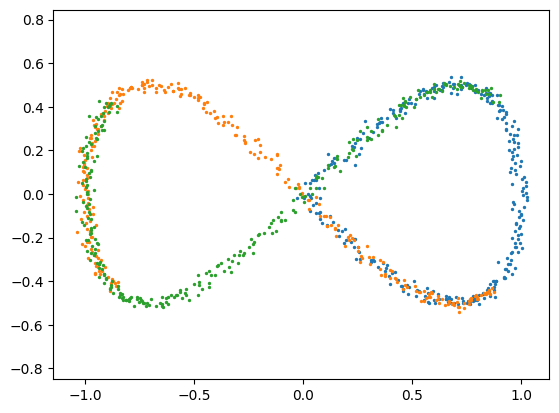

In [7]:
num_clusters = 3
samples_per_cluster = 300
labels, data = make_banana_data(num_clusters, samples_per_cluster, 0.02)


for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 [12 pts] Implement the missing lines in the below code, to complete the $\texttt{elbo}$ function for a variational autoencoder.

The banana dataset and an example encoder / decoder is provided just to help you debug.


In [8]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0])) #N(0,1)

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):

    mean, log_std = recognition_net(data)
    z_samples = diag_gaussian_samples(mean, log_std, num_samples=len(data)) # N,B,D
    log_q_z_given_x = diag_gaussian_logpdf(z_samples, mean, log_std) # N,B

    log_p_joint = log_joint(decoder_net, z_samples, data) # N,B

    return (log_p_joint - log_q_z_given_x).mean()

The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [9]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-9-26fe4ed13568>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  0%|          | 3/2000 [00:00<01:10, 28.47it/s]

Iteration 0 lower bound -30.80216407775879


  6%|▌         | 116/2000 [00:00<00:13, 136.09it/s]

Iteration 100 lower bound -1.554414987564087


 11%|█         | 217/2000 [00:01<00:13, 134.56it/s]

Iteration 200 lower bound -1.2060739994049072


 16%|█▌        | 314/2000 [00:02<00:14, 118.70it/s]

Iteration 300 lower bound -1.058545470237732


 21%|██        | 422/2000 [00:03<00:11, 131.58it/s]

Iteration 400 lower bound -0.9107875823974609


 26%|██▌       | 518/2000 [00:04<00:11, 131.32it/s]

Iteration 500 lower bound -0.9187958836555481


 31%|███       | 615/2000 [00:04<00:10, 129.48it/s]

Iteration 600 lower bound -0.930735170841217


 36%|███▌      | 724/2000 [00:05<00:10, 124.76it/s]

Iteration 700 lower bound -0.8683523535728455


 41%|████      | 813/2000 [00:06<00:09, 124.97it/s]

Iteration 800 lower bound -0.7928377389907837


 46%|████▌     | 914/2000 [00:07<00:11, 98.42it/s]

Iteration 900 lower bound -0.8371233940124512


 51%|█████     | 1015/2000 [00:08<00:11, 87.62it/s]

Iteration 1000 lower bound -0.7813522219657898


 56%|█████▌    | 1118/2000 [00:09<00:06, 130.21it/s]

Iteration 1100 lower bound -0.8107982277870178


 61%|██████    | 1216/2000 [00:10<00:06, 129.27it/s]

Iteration 1200 lower bound -0.8066538572311401


 66%|██████▌   | 1314/2000 [00:10<00:05, 130.47it/s]

Iteration 1300 lower bound -0.7385263442993164


 71%|███████▏  | 1426/2000 [00:11<00:04, 133.75it/s]

Iteration 1400 lower bound -0.7717119455337524


 76%|███████▌  | 1519/2000 [00:12<00:04, 113.59it/s]

Iteration 1500 lower bound -0.9115538597106934


 81%|████████  | 1618/2000 [00:13<00:02, 134.25it/s]

Iteration 1600 lower bound -0.8259062767028809


 86%|████████▌ | 1715/2000 [00:14<00:02, 121.14it/s]

Iteration 1700 lower bound -0.7216512560844421


 91%|█████████ | 1814/2000 [00:14<00:01, 136.37it/s]

Iteration 1800 lower bound -0.8441981673240662


 96%|█████████▋| 1926/2000 [00:15<00:00, 132.16it/s]

Iteration 1900 lower bound -0.765907347202301


100%|██████████| 2000/2000 [00:16<00:00, 122.68it/s]


## 2.2 [5 pts]  In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


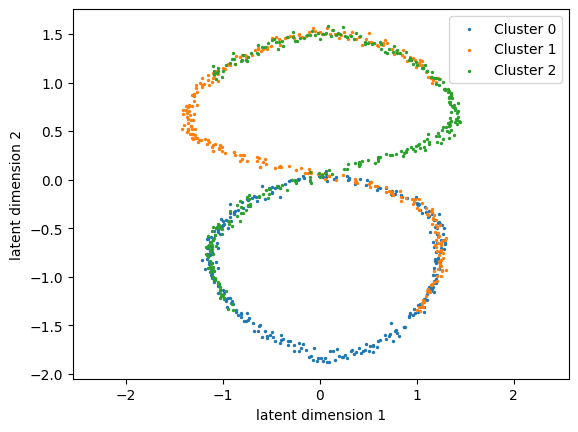

In [10]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    cur_data = data[labels == k]
    transformed = recognition_net(cur_data)[0]
    transformed = transformed.detach()
    plt.scatter(transformed[:,0], transformed[:,1], s=2, label=f'Cluster {k}')

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")
plt.legend()
plt.show()

## 2.3 [4pts] Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1500 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  


In [11]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1500
samples = diag_gaussian_samples(torch.tensor([0,0]), torch.tensor([0,0]), num_samples)
transformed = decoder_net(samples)[0]
transformed = transformed.detach()


Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


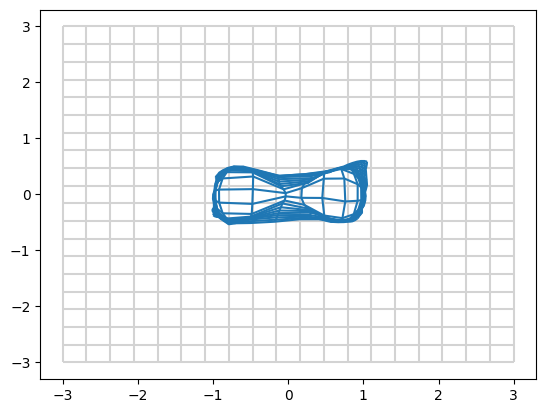

In [12]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



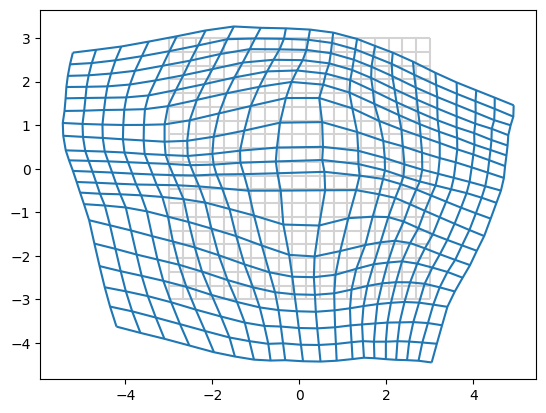

In [14]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()